In [1]:
import pylab as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
medical_data = pd.read_csv("dataset/other_train.csv")
personal_data = pd.read_csv("dataset/personal_train.csv")

V predchádzajúcej časti sme v oboch súboroch idetifikovali dva nepomenované stĺpce, ktoré pre nás nemajú žiaden význam,
takže ich teraz môžeme z oboch datasetov odstrániť.

In [3]:
personal_data = personal_data.drop(personal_data.columns[0], axis=1)
medical_data = medical_data.drop(medical_data.columns[0], axis=1)

Dáta spojíme do jednej tabuľky, keďže jedno pozorovanie musí byť opísané len jedným riadkom.

In [4]:
data = pd.merge(personal_data, medical_data, on = ["name", "address"], how = "outer")
data_backup = data

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3983 non-null   object 
 1   address           3983 non-null   object 
 2   age               3983 non-null   int64  
 3   sex               3983 non-null   object 
 4   date_of_birth     3983 non-null   object 
 5   kurtosis_oxygen   3974 non-null   float64
 6   pregnant          3971 non-null   object 
 7   education-num     3579 non-null   float64
 8   relationship      3961 non-null   object 
 9   skewness_glucose  3965 non-null   float64
 10  mean_glucose      3963 non-null   float64
 11  std_oxygen        3967 non-null   float64
 12  capital-gain      3969 non-null   float64
 13  skewness_oxygen   3975 non-null   float64
 14  kurtosis_glucose  3968 non-null   float64
 15  personal_info     3974 non-null   object 
 16  education         3971 non-null   object 


Ako prvé môžeme premenovať stĺpce class a fnlwgt, aby ich názvy boli viacej informatívne.

In [5]:
def rename_columns(X):
    X = X.rename(columns = {'fnlwgt': 'final_weight', 'class': 'diabetes_presence'}, inplace = False)
    return X

### Úprava chybných atribútov

V tejto časti opravíme chyby, ktoré sme idetifikovali v predchádzajúcej časti projektu, prípadne aj novo-objavené chyby,
ak na ne narazíme.


V doleuvedenej tabuľke vidíme chybu v atribúte age. Minimálny vek má hodnotu -1, čo je samozrejme nesprávne. Môžeme to
vyriešiť, tak, že vyrátame nový vek pacienta, keďže máme aj atribút date_of_birth. Toto funguje len za predpokladu, že
date_of_birth nemá nulovú hodnotu a bol zadaný správne. Iným riešením by mohlo byť nahradenie záporného veku
priemerným, alebo najčastejšie sa vyskytujúcim vekom všetkých pacientov.

In [6]:
data["age"].describe()

count    3983.000000
mean       51.844841
std        11.797919
min        -1.000000
25%        44.000000
50%        52.000000
75%        60.000000
max       113.000000
Name: age, dtype: float64

Každý pacient má zadaný vek a dátum narodenia, čiže môžeme vytvoriť funkciu, ktorá vyráta nový vek podľa dátumu.

In [7]:
print(sum(data["age"].isnull()))
print(sum(data["date_of_birth"].isnull()))

0
0


In [8]:
data["date_of_birth"].head(40)

0              1955-08-04
1              1974-05-17
2              1977-01-13
3              28/12/1957
4              1962-07-07
5              1957-03-16
6              1943/07/04
7              1984-05-13
8              1971-05-10
9              1986-11-13
10             1978-11-10
11             1967/07/20
12    1959-01-25 00:00:00
13             1959-12-05
14             1968-10-05
15             1957-06-28
16             1977-04-02
17             1968-05-22
18             1968-05-22
19             1960-12-25
20             30/08/1986
21             1941-07-25
22    1960-05-01 00 00 00
23             1959-01-25
24             1972-10-31
25             1951-06-17
26             1960-11-22
27             1960-09-18
28             1970-04-06
29    1974-09-28 00:00:00
30               77-04-12
31    1950-06-21 00 00 00
32             1955-04-05
33             1955-04-05
34               66-10-30
35             17/08/1964
36             1951-08-18
37             1979-11-29
38          

Ako môžeme vidieť, dátum nemá jednotný formát, čiže bude nutné vytvoriť funkciu, ktorá tento problém odstráni. Vyzerá,
že najpoužívanejší typ formátovania je YYYY-MM-DD, čiže všetky dátumy naň prehodíme.

In [9]:
def unify_date_format(X):
    X["date_of_birth"] = X["date_of_birth"].map(format_date)
    
    return X

def format_date(date):

    date = str(date).replace("/", "-")
    date = date[:10]
    date = date.split("-")

    # if date format DD-MM-YYYY
    if len(date[2]) == 4:
        date = date[2] + "-" + date[1] + "-" + date[0]
        return date

    # if date format YY-MM-DD
    elif len(date[0]) == 2 and len(date[2]) == 2:
        date = "19" + date[0] + "-" + date[1] + "-" + date[2]
        return date

    date = "-".join(date)
    return date

In [10]:
# unify_date_format(data)['date_of_birth'].head(25)

Dole môžeme vidieť, že záporný vek vznikol kvôli nesprávnej hodnote dátumu. Na jeho miesto môžeme teda dosadiť
medián veku pacientov s kladným vekom. Týmto odstránime problém záporných hodnôt pri veku.

In [11]:
def fix_age(X):
    age_median = X[(X["age"] > 0)].age.median()
    X.loc[(X["age"] < 0), "age"] = int(age_median)
    
    return X


# fix_age(data)

Čo sa týka atribútu sex, obsahuje len dve hodnoty, ktoré môžeme reprezentovať aj číselne. Je to nutné, keďže v ďalšej
fáze budeme robiť s algoritmami pracujúcimi len s numerickými dátami. Pohlavia budeme reprezentovať nasledovne:
- Male = 1
- Female = 0

In [12]:
def unify_sex_format(X):
    X['sex'] =  X["sex"].map(fix_sex_value)
    
    return X

def fix_sex_value(sex):
    if sex.strip() == "Male":
        return 1
    else:
        return 0

V minulej časti projektu sme ukázali, že atribút pregnant nadobúda priveľa hodnôt, ktoré symbolizujú ten istý stav.
Preto ich, rovnako ako pohlavie, nahradíme číslami 1 a 0.

In [13]:
print(data["pregnant"].unique())
print(sum(data["pregnant"].isnull()))

['f' 'FALSE' 'T' 'F' 'TRUE' 't' nan]
12


In [14]:
def unify_pregnancy_format(X):
    X["pregnant"] = X["pregnant"].map(format_pregnancy)
    
    return X

def format_pregnancy(value):

    try:
        if value.strip() in ['t','T','TRUE']:
            return 1
        elif value.strip() in ['f','F','FALSE']:
            return 0
        else:
            return np.nan
        
    except AttributeError:
        return np.nan

Atribút pregnant nastavíme na 0 u všetkých mužov, je možné, že tým odstránime niektoré nulové hodnoty, alebo opravíme
prípadné chyby.

In [15]:
def fix_male_pregnancy(X):
    X.loc[(X.sex == 1), "pregnant"] = 0
    
    return X

Počet prázdnych hodnôt ostal rovnaký, no tým sa budeme venovať nižšie, kde vyriešime problémy s prázdnymi hodnotami
všetkých atribútov.

### Odstraňovanie duplicitných záznamov

Nakoniec sme sa rozhodli, že duplicitné záznamy určíme pomocou mena a adresy. Tie následne môžeme odstrániť.
Pre každý záznam v súbore personal_train môžeme priradiť záznam zo súboru other_train, teda celkový výsledný
dataset má mať počet záznamov menšieho z oboch súborov.

In [16]:
print("Number of rows in personal_train.csv ", len(personal_data))
print("Number of rows in other_train.csv ", len(medical_data))
print("Number of rows combined: ", len(data))
print("Number of duplicates: ", len(data[data.duplicated(["name", "address"])]))

Number of rows in personal_train.csv  3933
Number of rows in other_train.csv  3983
Number of rows combined:  3983
Number of duplicates:  50


In [17]:
def delete_duplicates(X):
    X = X.drop_duplicates(["name", "address"])
    
    return X

print("Number of rows combined: ", len(data))
print("Number of duplicates: ", len(data[data.duplicated(["name", "address"])]))

Number of rows combined:  3983
Number of duplicates:  50


In [18]:
column_dict = {}

In [19]:
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer

class CleanData(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        X = unify_date_format(X)
        X = delete_duplicates(X)
        X = fix_male_pregnancy(X)
        X = unify_pregnancy_format(X)
        X = unify_sex_format(X)
        X = fix_age(X)
        X = rename_columns(X)
        
        X = X.drop(columns=['name', 'address', 'relationship', 'personal_info', 'education', 'income', 'date_of_birth'])
        
        list_columns = X.columns.tolist()
        for col in list_columns:
            column_dict[col] = list_columns.index(col)
        
        return X.values

In [20]:

# method = median alebo mean
class MissingValues(TransformerMixin):
    def __init__(self, method, columns):
        self.method = method
        self.columns = columns
        self.imputer = None
        
        
        if method == 'median':
            self.imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        if method == 'mean':
            self.imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            
            id = column_dict[col]
            
            if self.method == 'median':
                
                median = np.nanmedian(X[: , id])
                print("Median stlpca", col, median)
                
                for i, value in enumerate(X[: , id]):
                        if pd.isnull(value) or value == np.nan:
                            X[i][id] = median
                            
            elif self.method == 'mean':
                mean = np.nanmean(X[: , id])
                
                for i, value in enumerate(X[: , id]):
                        if pd.isnull(value) or value == np.nan:
                            X[i][id] = mean
                            
            elif self.method == 'delete':
                     # X.drop(X[X[col].isnull()].index, inplace = True)
                    indices_to_delete = []
                    for i, value in enumerate(X[: , id]):
                        if pd.isnull(value) or value == np.nan:
                            indices_to_delete.append(i)
            
                    X = np.delete(X, indices_to_delete, axis=0)
            
        return X

In [21]:
# Interquartile outlier removal
class OutlierDetection(TransformerMixin):
    def __init__(self, method, columns):
        self.method = method
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            
            id = column_dict[col]
            
            quantiles = np.quantile(X[: , id], [0.05, 0.95])
            
            for i, value in enumerate(X[: , id]):
                
                if value < quantiles[0]:
                    X[i][id] = np.nan if self.method == 'nan' else quantiles[0]
                if value > quantiles[1]:
                    X[i][id] = np.nan if self.method == 'nan' else quantiles[1]
            
            #print('Identified outliers: %d' % len(outliers))
            
        return X

In [22]:
class Imputer:
    def __init__(self, columns, neighbours):
        self.columns = columns
        self.imputer = KNNImputer(n_neighbors=neighbours)

    def fit(self, X, y=None):
        #for col in self.columns:
         #   X[col] = X[col].reshape([len(X[col]), 1])
        
        return self

    def transform(self, X):
        for col in self.columns:
            
            id = column_dict[col]
            
            lenght = len(X[: , id])
            reshaped_col = X[: , id].reshape(lenght , 1)
            self.transformer = self.imputer.fit(reshaped_col)
            
            X[: , id] = self.imputer.transform(reshaped_col).reshape(lenght)
                
        return X

In [23]:
from sklearn.preprocessing import PowerTransformer

class PowerTransform(TransformerMixin):
    def __init__(self, method, columns):
        self.columns = columns
        self.transformer = PowerTransformer(method=method, standardize=True) 

    def fit(self, X, y=None):
        #for col in self.columns:
         #   X[col] = X[col].reshape([len(X[col]), 1])
        
        return self

    def transform(self, X):
        for col in self.columns:
            
            id = column_dict[col]
            
            lenght = len(X[: , id])
            reshaped_col = X[: , id].reshape(lenght , 1)
            self.transformer = self.transformer.fit(reshaped_col)
            
            X[: , id] = self.transformer.transform(reshaped_col).reshape(lenght)
                
        return X

In [24]:
from sklearn.pipeline import Pipeline

list_delete = ['diabetes_presence']
list_mean = ['kurtosis_oxygen','skewness_glucose', 'mean_glucose', 'std_oxygen', 'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'final_weight']
list_median = ['education-num', 'capital-gain', 'age', 'pregnant', 'hours-per-week', 'capital-loss']
list_outliers = [
    'kurtosis_oxygen', 'skewness_glucose', 'mean_glucose', 'std_oxygen',
    'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen',
    'capital-gain', 'final_weight', 'capital-loss'
]
list_transform_yeo = ['education-num', 'kurtosis_oxygen', 'skewness_glucose', 'mean_glucose', 'std_oxygen', 'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen']

pipeline1 =  Pipeline([
    ('Clean_data', CleanData()),
    ('Missing_values_delete',  MissingValues('delete', list_delete)),
    ('Missing_values_median',  MissingValues('median', list_median)),
    ('Missing_values_mean',  MissingValues('mean', list_mean)),
    ('Outliers', OutlierDetection('percentile', list_outliers)),
    ('Transformer_yeo', PowerTransform('yeo-johnson', list_transform_yeo)),
])


In [25]:
list_delete = ['diabetes_presence']
list_mean = []
list_median = ['education-num', 'capital-gain', 'age', 'pregnant', 'hours-per-week', 'capital-loss']
list_outliers_nan = [
    'kurtosis_oxygen', 'skewness_glucose', 'mean_glucose', 'std_oxygen',
    'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen',
]

list_outliers_percentile = ['capital-gain', 'final_weight', 'capital-loss']
list_transform_yeo = ['education-num', 'kurtosis_oxygen', 'skewness_glucose', 'mean_glucose', 'std_oxygen', 'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen']
list_imputer = ['kurtosis_oxygen','skewness_glucose', 'mean_glucose', 'std_oxygen', 'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'final_weight']

pipeline2 =  Pipeline([
    ('Clean_data', CleanData()),
    ('Missing_values_delete',  MissingValues('delete', list_delete)),
    ('Missing_values_median',  MissingValues('median', list_median)),
    ('Outliers_nan', OutlierDetection('nan', list_outliers_nan)),
    ('Knn_impute', Imputer(list_imputer, 10)),
    ('Outliers_percentile', OutlierDetection('percentile', list_outliers_percentile)),
    ('Transformer_yeo', PowerTransform('yeo-johnson', list_transform_yeo)),
])

In [26]:
# y = data[['diabetes_presence']]
data_pipe1 = data.copy(deep=True)
data_pipe2 = data.copy(deep=True)


X_trans_1 = pipeline1.fit_transform(data_pipe1)
X_trans_2 = pipeline2.fit_transform(data_pipe2)

all_columns = [k for k in column_dict]

new_X_1 = pd.DataFrame(data=X_trans_1, columns=all_columns)
new_X_2 = pd.DataFrame(data=X_trans_2, columns=all_columns)

d:\programming\python\iau_projekt\venv\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-14-b550ae78f0c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["pregnant"] = X["pregnant"].map(format_pregnancy)
d:\programming\python\iau_projekt\venv\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Median stlpca education-num 10.0
Median stlpca capital-gain 0.0
Median stlpca age 52.0
Median stlpca pregnant 0.0
Median stlpca hours-per-week 40.0
Median stlpca capital-loss 0.0
Median stlpca education-num 10.0
Median stlpca capital-gain 0.0
Median stlpca age 52.0
Median stlpca pregnant 0.0
Median stlpca hours-per-week 40.0
Median stlpca capital-loss 0.0


<ipython-input-27-85169fd7643e>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data.hist(ax=ax)


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'kurtosis_oxygen'}>,
        <AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'skewness_glucose'}>],
       [<AxesSubplot:title={'center':'mean_glucose'}>,
        <AxesSubplot:title={'center':'std_oxygen'}>,
        <AxesSubplot:title={'center':'capital-gain'}>,
        <AxesSubplot:title={'center':'skewness_oxygen'}>],
       [<AxesSubplot:title={'center':'kurtosis_glucose'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>,
        <AxesSubplot:title={'center':'class'}>,
        <AxesSubplot:title={'center':'std_glucose'}>],
       [<AxesSubplot:title={'center':'mean_oxygen'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>,
        <AxesSubplot:title={'center':'capital-loss'}>, <AxesSubplot:>]],
      dtype=object)

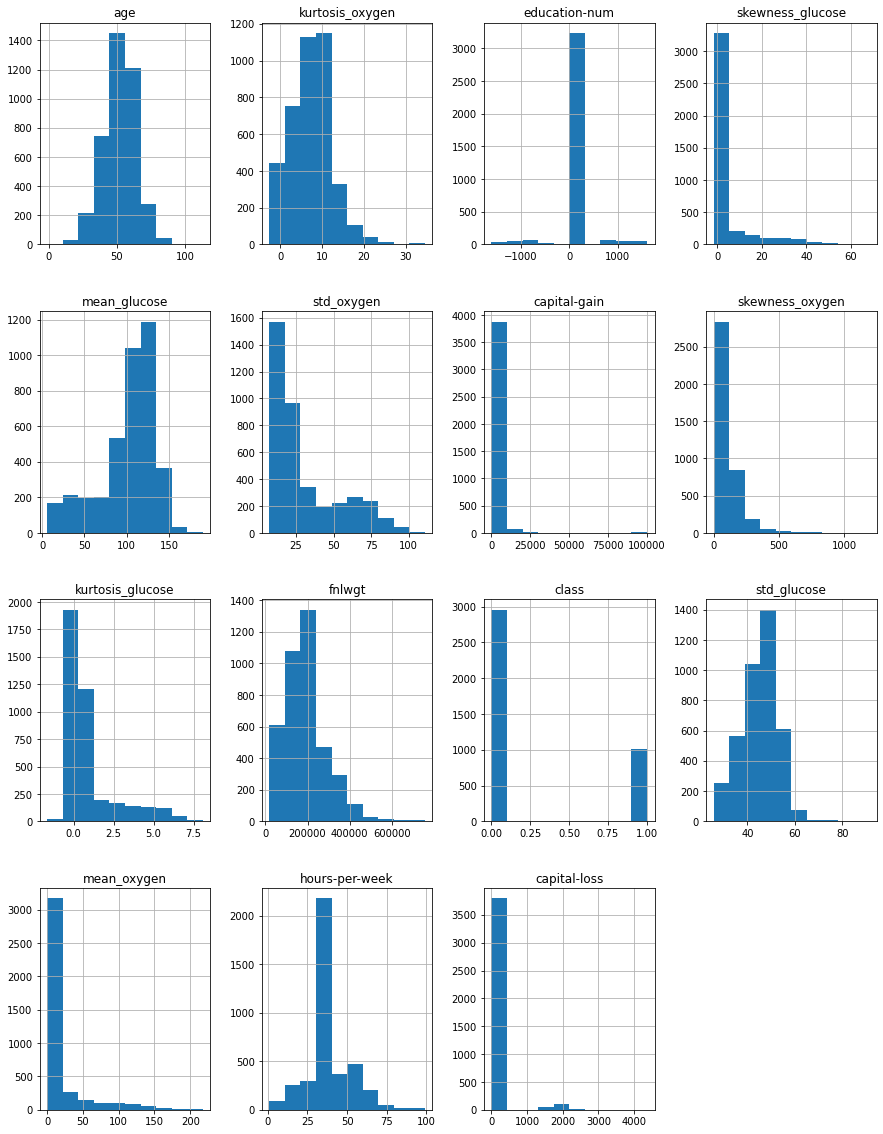

In [27]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax=ax)

<ipython-input-32-ec04458495fd>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  new_X_1.hist(ax = ax)


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'kurtosis_oxygen'}>,
        <AxesSubplot:title={'center':'pregnant'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'skewness_glucose'}>,
        <AxesSubplot:title={'center':'mean_glucose'}>,
        <AxesSubplot:title={'center':'std_oxygen'}>],
       [<AxesSubplot:title={'center':'capital-gain'}>,
        <AxesSubplot:title={'center':'skewness_oxygen'}>,
        <AxesSubplot:title={'center':'kurtosis_glucose'}>,
        <AxesSubplot:title={'center':'final_weight'}>],
       [<AxesSubplot:title={'center':'diabetes_presence'}>,
        <AxesSubplot:title={'center':'std_glucose'}>,
        <AxesSubplot:title={'center':'mean_oxygen'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=o

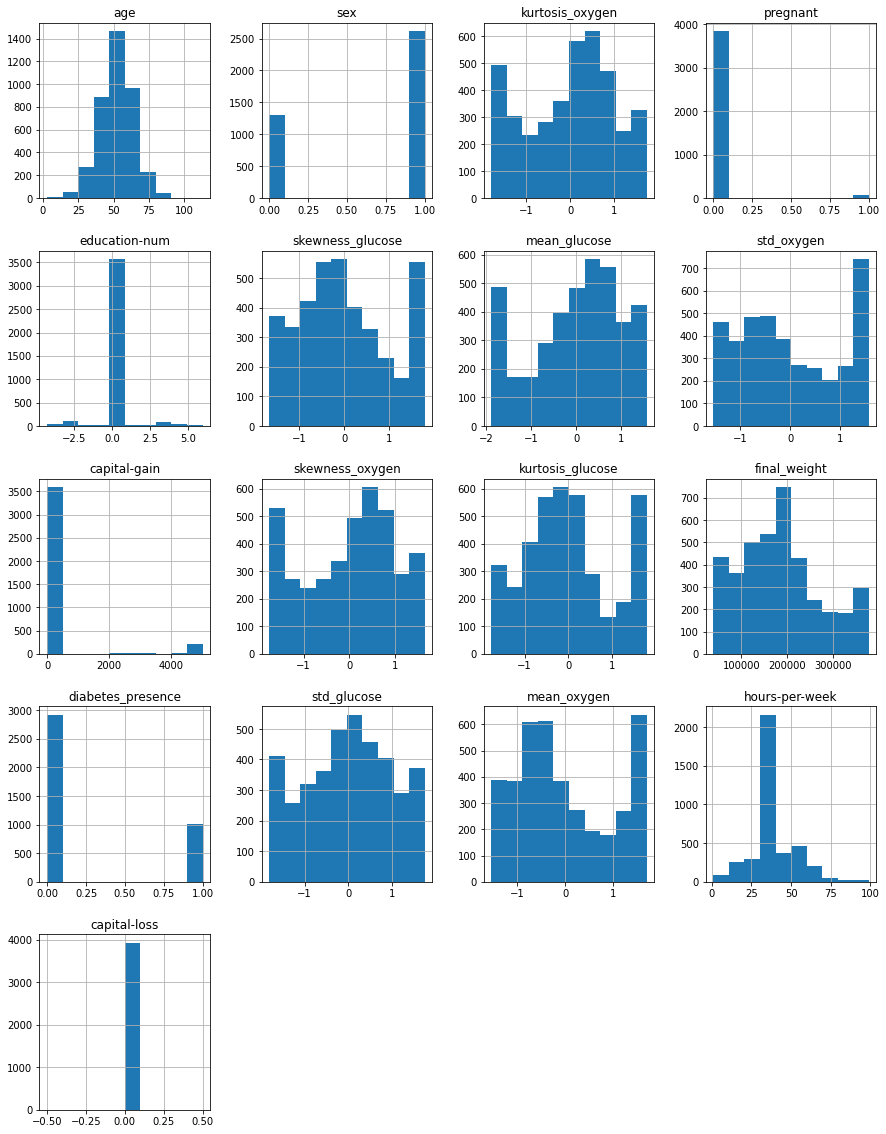

In [32]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
new_X_1.hist(ax = ax)

<ipython-input-31-7099cd2cd730>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  new_X_2.hist(ax = ax)


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'kurtosis_oxygen'}>,
        <AxesSubplot:title={'center':'pregnant'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'skewness_glucose'}>,
        <AxesSubplot:title={'center':'mean_glucose'}>,
        <AxesSubplot:title={'center':'std_oxygen'}>],
       [<AxesSubplot:title={'center':'capital-gain'}>,
        <AxesSubplot:title={'center':'skewness_oxygen'}>,
        <AxesSubplot:title={'center':'kurtosis_glucose'}>,
        <AxesSubplot:title={'center':'final_weight'}>],
       [<AxesSubplot:title={'center':'diabetes_presence'}>,
        <AxesSubplot:title={'center':'std_glucose'}>,
        <AxesSubplot:title={'center':'mean_oxygen'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=o

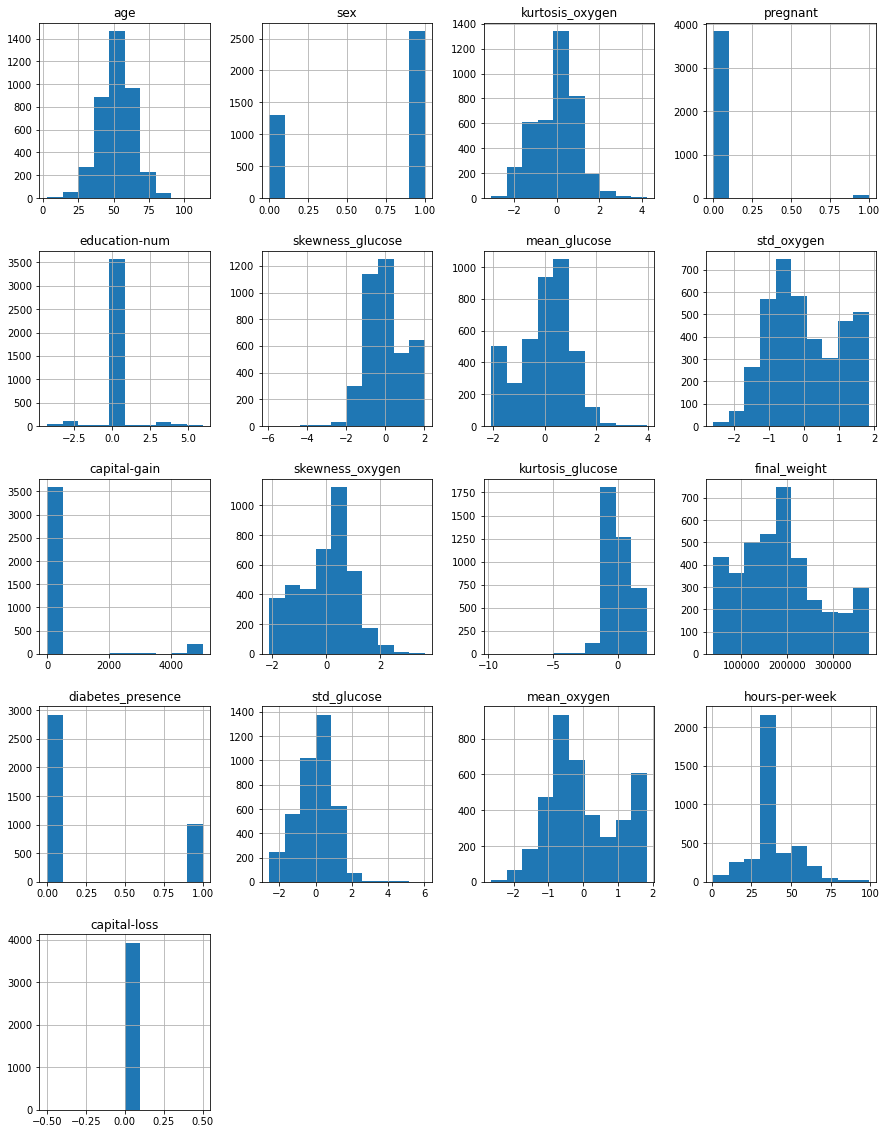

In [31]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
new_X_2.hist(ax = ax)

In [29]:
new_X_1.isnull().any()

age                  False
sex                  False
kurtosis_oxygen      False
pregnant             False
education-num        False
skewness_glucose     False
mean_glucose         False
std_oxygen           False
capital-gain         False
skewness_oxygen      False
kurtosis_glucose     False
final_weight         False
diabetes_presence    False
std_glucose          False
mean_oxygen          False
hours-per-week       False
capital-loss         False
dtype: bool

In [30]:
new_X_2.isnull().any()

age                  False
sex                  False
kurtosis_oxygen      False
pregnant             False
education-num        False
skewness_glucose     False
mean_glucose         False
std_oxygen           False
capital-gain         False
skewness_oxygen      False
kurtosis_glucose     False
final_weight         False
diabetes_presence    False
std_glucose          False
mean_oxygen          False
hours-per-week       False
capital-loss         False
dtype: bool